In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Import the dataset
items=pd.read_csv('items.csv')
shops=pd.read_csv('shops.csv')
cats=pd.read_csv('item_categories.csv')
train=pd.read_csv('sales_train_v2.csv')
test=pd.read_csv('test.csv').set_index('ID')

In [3]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [4]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [5]:
cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [6]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [7]:
test.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


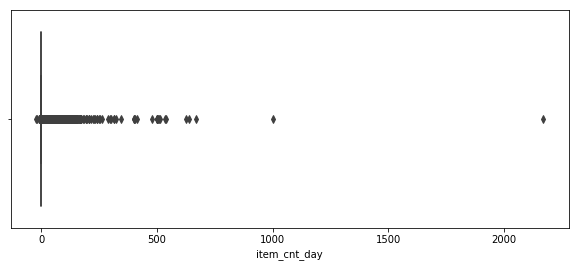

In [8]:
# take care of outliers
plt.figure(figsize=(10,4))
sns.boxplot(x=train['item_cnt_day'])

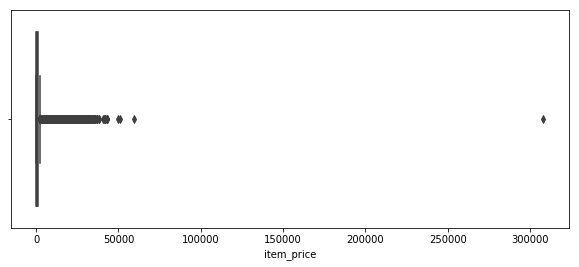

In [9]:
plt.figure(figsize=(10,4))
sns.boxplot(x=train['item_price'])

In [10]:
train=train[train['item_price']<100000]
train=train[train['item_cnt_day']<=1000]

In [11]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [12]:
train[train['item_price']<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [13]:
# Replace the item price with the median
median_set=train.drop(train.index[484683])

In [14]:
median=median_set['item_price'].median()

In [15]:
train.loc[train['item_price']<0, 'item_price'] = median

In [16]:
# Deal with the duplicates of shops
train.loc[train['shop_id']==0,'shop_id']=57
test.loc[test['shop_id']==0,'shop_id']=57

train.loc[train['shop_id']==1,'shop_id']=58
test.loc[test['shop_id']==1,'shop_id']=58

train.loc[train['shop_id']==10,'shop_id']=11
test.loc[test['shop_id']==10,'shop_id']=11

In [17]:
# Preprocessing data sets
shops.loc[shops['shop_name']=='Сергиев Посад ТЦ "7Я"','shop_name']='СергиевПосад ТЦ "7Я"'
shops['city']=shops['shop_name'].str.split(' ').map(lambda x:x[0])
shops.loc[shops['city']=='!Якутск','city']='Якутск'
from sklearn.preprocessing import LabelEncoder
shops['city_code']=LabelEncoder().fit_transform(shops['city'])
shops=shops[['shop_id','city_code']]

In [18]:
cats['split']=cats['item_category_name'].str.split('-')
cats['type']=cats['split'].map(lambda x:x[0].strip())
cats['type_code']=LabelEncoder().fit_transform(cats['type'])
cats['subtype']=cats['split'].map(lambda x:x[1].strip() if len(x)>1 else x[0].strip())
cats['subtype_code']=LabelEncoder().fit_transform(cats['subtype'])
cats=cats[['item_category_id','type_code','subtype_code']]

In [19]:
items=items.drop(columns='item_name',axis=1)

In [20]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [21]:
from itertools import product
matrix=[]
cols=['date_block_num','shop_id','item_id']
for i in range(34):
    sales=train[train['date_block_num']==i]
    matrix.append(np.array(list(product([i],sales['shop_id'].unique(),sales['item_id'].unique())),dtype='int16'))

In [22]:
matrix=pd.DataFrame(np.vstack(matrix),columns=cols)

In [23]:
matrix.head()

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564


In [24]:
matrix['date_block_num']=matrix['date_block_num'].astype(np.int8)
matrix['shop_id']=matrix['shop_id'].astype(np.int8)
matrix['item_id']=matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

In [25]:
train['revenue']=train['item_price']*train['item_cnt_day']

In [26]:
group=train.groupby(cols).agg({'item_cnt_day':['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

In [27]:
group.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0


In [29]:
matrix=pd.merge(matrix,group,on=cols,how='left')

In [30]:
matrix['item_cnt_month'] = (matrix['item_cnt_month'].fillna(0).astype(np.float16))

In [31]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0


In [32]:
test['date_block_num']=34
test['date_block_num']=test['date_block_num'].astype('int8')
test['shop_id']=test['shop_id'].astype(np.int8)
test['item_id']=test['item_id'].astype(np.int16)

In [33]:
matrix=pd.concat([matrix,test],ignore_index=True,sort=False,keys=cols)

In [39]:
matrix.fillna(0,inplace=True)

In [40]:
matrix=pd.merge(matrix,shops,on=['shop_id'],how='left')
matrix=pd.merge(matrix,items,on=['item_id'],how='left')
matrix=pd.merge(matrix,cats,on=['item_category_id'],how='left')
matrix['city_code']=matrix['city_code'].astype(np.int8)
matrix['item_category_id']=matrix['item_category_id'].astype(np.int8)
matrix['type_code']=matrix['type_code'].astype(np.int8)
matrix['subtype_code']=matrix['subtype_code'].astype(np.int8)

In [45]:
def lag_feature(df,lags,col):
    tmp=df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted=tmp.copy()
        shifted.columns=['date_block_num','shop_id','item_id',col+'_lag_'+str(i)]
        shifted['date_block_num']+=i
        df=pd.merge(df,shifted,on=['date_block_num','shop_id','item_id'],how='left')
    return df

In [46]:
matrix=lag_feature(matrix,[1,2,3,4,5,6,12],'item_cnt_month')

In [48]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,2,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
# Mean Fearues
group=matrix.groupby(['date_block_num']).agg({'item_cnt_month':['mean']})
group.columns=['date_avg_item_cnt']
group.reset_index(inplace=True)

In [51]:
matrix=pd.merge(matrix,group,on=['date_block_num'],how='left')
matrix['date_avg_item_cnt']=matrix['date_avg_item_cnt'].astype(np.float16)
matrix=lag_feature(matrix,[1],'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'],axis=1,inplace=True)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1
0,0,2,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
group=matrix.groupby(['date_block_num','item_id']).agg({'item_cnt_month':['mean']})
group.columns=['date_item_avg_item_cnt']
group.reset_index(inplace=True)

In [54]:
matrix=pd.merge(matrix,group,on=['date_block_num','item_id'],how='left')
matrix['date_item_avg_item_cnt']=matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix=lag_feature(matrix,[1,2,3,6,12],'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'],axis=1,inplace=True)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12
0,0,2,19,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0,30,8,55,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0,23,5,16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
group=matrix.groupby(['date_block_num','shop_id']).agg({'item_cnt_month':['mean']})
group.columns=['date_shop_avg_item_cnt']
group.reset_index(inplace=True)

In [56]:
matrix=pd.merge(matrix,group,on=['date_block_num','shop_id'],how='left')
matrix['date_shop_avg_item_cnt']=matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix=lag_feature(matrix,[1,2,3,6,12],'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'],axis=1,inplace=True)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12
0,0,2,19,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0,30,8,55,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0,23,5,16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
group=matrix.groupby(['date_block_num','item_category_id']).agg({'item_cnt_month':['mean']})
group.columns=['date_cat_avg_item_cnt']
group.reset_index(inplace=True)

In [59]:
matrix=pd.merge(matrix,group,on=['date_block_num','item_category_id'],how='left')
matrix['date_cat_avg_item_cnt']=matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix=lag_feature(matrix,[1],'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'],axis=1,inplace=True)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_catshop_avg_item_cnt,date_cat_avg_item_cnt_lag_1
0,0,2,19,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.310791,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.849609,NaN
2,0,2,28,0.0,0,30,8,55,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.189453,NaN
3,0,2,29,0.0,0,23,5,16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.548828,NaN
4,0,2,32,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.310791,NaN


In [63]:
group=matrix.groupby(['date_block_num','shop_id','item_category_id']).agg({'item_cnt_month':['mean']})
group.columns=['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

In [64]:
matrix=pd.merge(matrix,group,on=['date_block_num','shop_id','item_category_id'],how='left')
matrix['date_shop_cat_avg_item_cnt']=matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix=lag_feature(matrix,[1],'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'],axis=1,inplace=True)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_catshop_avg_item_cnt,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1
0,0,2,19,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.310791,NaN,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.849609,NaN,NaN
2,0,2,28,0.0,0,30,8,55,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.189453,NaN,NaN
3,0,2,29,0.0,0,23,5,16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.548828,NaN,NaN
4,0,2,32,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.310791,NaN,NaN


In [65]:
group=matrix.groupby(['date_block_num','shop_id','type_code']).agg({'item_cnt_month':['mean']})
group.columns=['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

In [66]:
matrix=pd.merge(matrix,group,on=['date_block_num','shop_id','type_code'],how='left')
matrix['date_shop_type_avg_item_cnt']=matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix=lag_feature(matrix,[1],'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'],axis=1,inplace=True)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_catshop_avg_item_cnt,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1
0,0,2,19,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.310791,NaN,NaN,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.849609,NaN,NaN,NaN
2,0,2,28,0.0,0,30,8,55,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.189453,NaN,NaN,NaN
3,0,2,29,0.0,0,23,5,16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.548828,NaN,NaN,NaN
4,0,2,32,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.310791,NaN,NaN,NaN


In [67]:
group=matrix.groupby(['date_block_num','shop_id','subtype_code']).agg({'item_cnt_month':['mean']})
group.columns=['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

In [68]:
matrix=pd.merge(matrix,group,on=['date_block_num','shop_id','subtype_code'],how='left')
matrix['date_shop_subtype_avg_item_cnt']=matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix=lag_feature(matrix,[1],'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'],axis=1,inplace=True)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_catshop_avg_item_cnt,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1
0,0,2,19,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.310791,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.849609,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0,30,8,55,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.189453,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0,23,5,16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.548828,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.310791,NaN,NaN,NaN,NaN


In [69]:
group=matrix.groupby(['date_block_num','city_code']).agg({'item_cnt_month':['mean']})
group.columns=['date_city_avg_item_cnt']
group.reset_index(inplace=True)

In [70]:
matrix=pd.merge(matrix,group,on=['date_block_num','city_code'],how='left')
matrix['date_city_avg_item_cnt']=matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix=lag_feature(matrix,[1],'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'],axis=1,inplace=True)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_catshop_avg_item_cnt,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1
0,0,2,19,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,0.310791,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,...,NaN,NaN,NaN,NaN,0.849609,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0,30,8,55,NaN,NaN,...,NaN,NaN,NaN,NaN,1.189453,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0,23,5,16,NaN,NaN,...,NaN,NaN,NaN,NaN,0.548828,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,0.310791,NaN,NaN,NaN,NaN,NaN


In [71]:
group=matrix.groupby(['date_block_num','item_id','city_code']).agg({'item_cnt_month':['mean']})
group.columns=['date_item_city_avg_item_cnt']
group.reset_index(inplace=True)

In [72]:
matrix=pd.merge(matrix,group,on=['date_block_num','item_id','city_code'],how='left')
matrix['date_item_city_avg_item_cnt']=matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix=lag_feature(matrix,[1],'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'],axis=1,inplace=True)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_catshop_avg_item_cnt,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1
0,0,2,19,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,0.310791,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,...,NaN,NaN,NaN,0.849609,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0,30,8,55,NaN,NaN,...,NaN,NaN,NaN,1.189453,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0,23,5,16,NaN,NaN,...,NaN,NaN,NaN,0.548828,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,0.310791,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
group=matrix.groupby(['date_block_num','type_code']).agg({'item_cnt_month':['mean']})
group.columns=['date_type_avg_item_cnt']
group.reset_index(inplace=True)

In [74]:
matrix=pd.merge(matrix,group,on=['date_block_num','type_code'],how='left')
matrix['date_type_avg_item_cnt']=matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix=lag_feature(matrix,[1],'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'],axis=1,inplace=True)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_catshop_avg_item_cnt,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1
0,0,2,19,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,0.310791,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,...,NaN,NaN,0.849609,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0,30,8,55,NaN,NaN,...,NaN,NaN,1.189453,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0,23,5,16,NaN,NaN,...,NaN,NaN,0.548828,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,0.310791,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
group=matrix.groupby(['date_block_num','subtype_code']).agg({'item_cnt_month':['mean']})
group.columns=['date_subtype_avg_item_cnt']
group.reset_index(inplace=True)

In [76]:
matrix=pd.merge(matrix,group,on=['date_block_num','subtype_code'],how='left')
matrix['date_subtype_avg_item_cnt']=matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix=lag_feature(matrix,[1],'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'],axis=1,inplace=True)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_shop_avg_item_cnt_lag_12,date_catshop_avg_item_cnt,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1
0,0,2,19,0.0,0,40,11,4,NaN,NaN,...,NaN,0.310791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,...,NaN,0.849609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0,30,8,55,NaN,NaN,...,NaN,1.189453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0,23,5,16,NaN,NaN,...,NaN,0.548828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0,40,11,4,NaN,NaN,...,NaN,0.310791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
# Trend Features
group=train.groupby(['item_id']).agg({'item_price':['mean']})
group.columns=['item_avg_item_price']
group.reset_index(inplace=True)

In [78]:
matrix=pd.merge(matrix,group,on=['item_id'],how='left')
matrix['item_avg_item_price']=matrix['item_avg_item_price'].astype(np.float16)

In [79]:
group=train.groupby(['date_block_num','item_id']).agg({'item_price':['mean']})
group.columns=['date_item_avg_item_price']
group.reset_index(inplace=True)

In [80]:
matrix=pd.merge(matrix,group,on=['date_block_num','item_id'],how='left')
matrix['date_item_avg_item_price']=matrix['date_item_avg_item_price'].astype(np.float16)

In [83]:
lags=[1,2,3,4,5,6]

In [81]:
matrix=lag_feature(matrix,lags,'date_item_avg_item_price')

In [82]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,item_avg_item_price,date_item_avg_item_price,date_item_avg_item_price_lag_1,date_item_avg_item_price_lag_2,date_item_avg_item_price_lag_3,date_item_avg_item_price_lag_4,date_item_avg_item_price_lag_5,date_item_avg_item_price_lag_6
0,0,2,19,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,28.000,28.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,...,NaN,NaN,1461.000,2324.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0,30,8,55,NaN,NaN,...,NaN,NaN,310.000,549.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0,23,5,16,NaN,NaN,...,NaN,NaN,1759.000,2398.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,249.625,338.0,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
for i in lags:
    matrix['delta_price_lag_'+str(i)]=(matrix['date_item_avg_item_price_lag_'+str(i)]-matrix['item_avg_item_price'])/matrix['item_avg_item_price']

In [85]:
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
        return 0

In [86]:
matrix['delta_price_lag']=matrix.apply(select_trend,axis=1)
matrix['delta_price_lag']=matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0,inplace=True)

In [87]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_item_avg_item_price_lag_4,date_item_avg_item_price_lag_5,date_item_avg_item_price_lag_6,delta_price_lag_1,delta_price_lag_2,delta_price_lag_3,delta_price_lag_4,delta_price_lag_5,delta_price_lag_6,delta_price_lag
0,0,2,19,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,0,2,27,1.0,0,19,5,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,0,2,28,0.0,0,30,8,55,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,0,2,29,0.0,0,23,5,16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,0,2,32,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [88]:
drop_features=['item_avg_item_price','date_item_avg_item_price']
for i in lags:
    drop_features+=['date_item_avg_item_price_lag_'+str(i)]
    drop_features+=['delta_price_lag_'+str(i)]

In [89]:
matrix.drop(drop_features,axis=1,inplace=True)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_catshop_avg_item_cnt,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag
0,0,2,19,0.0,0,40,11,4,NaN,NaN,...,0.310791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,0,2,27,1.0,0,19,5,10,NaN,NaN,...,0.849609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,0,2,28,0.0,0,30,8,55,NaN,NaN,...,1.189453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,0,2,29,0.0,0,23,5,16,NaN,NaN,...,0.548828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,0,2,32,0.0,0,40,11,4,NaN,NaN,...,0.310791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [90]:
group=train.groupby(['date_block_num','shop_id']).agg({'revenue':['sum']})
group.columns=['date_shop_revenue']
group.reset_index(inplace=True)

In [91]:
matrix=pd.merge(matrix,group,on=['date_block_num','shop_id'],how='left')
matrix['date_shop_revenue']=matrix['date_shop_revenue'].astype(np.float32)

In [93]:
group=group.groupby(['shop_id']).agg({'date_shop_revenue':['mean']})
group.columns=['shop_avg_revenue']
group.reset_index(inplace=True)

In [94]:
matrix=pd.merge(matrix,group,on=['shop_id'],how='left')
matrix['shop_avg_revenue']=matrix['shop_avg_revenue'].astype(np.float32)

In [95]:
matrix['delta_revenue']=(matrix['date_shop_revenue']-matrix['shop_avg_revenue'])/matrix['shop_avg_revenue']
matrix['delta_revenue']=matrix['delta_revenue'].astype(np.float16)
matrix=lag_feature(matrix,[1],'delta_revenue')
matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'],axis=1,inplace=True)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1
0,0,2,19,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,0,2,28,0.0,0,30,8,55,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3,0,2,29,0.0,0,23,5,16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,0,2,32,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [96]:
# Special Features
matrix['month']=matrix['date_block_num']%12

In [97]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days']=matrix['month'].map(days).astype(np.int8)

In [98]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days
0,0,2,19,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31
1,0,2,27,1.0,0,19,5,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31
2,0,2,28,0.0,0,30,8,55,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31
3,0,2,29,0.0,0,23,5,16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31
4,0,2,32,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31


In [99]:
cache={}
matrix['item_shop_last_sale']=-1
matrix['item_shop_last_sale']=matrix['item_shop_last_sale'].astype(np.int8)
for idx,row in matrix.iterrows():
    key=str(row['item_id'])+' '+str(row['shop_id'])
    if key not in cache:
        if row['item_cnt_month']!=0:
            cache[key]=row['date_block_num']
    else:
        last_date_block_num=cache[key]
        matrix.at[idx,'item_shop_last_sale']=row['date_block_num']-last_date_block_num
        cache[key]=row['date_block_num']

In [100]:
cache={}
matrix['item_last_sale']=-1
matrix['item_last_sale']=matrix['item_last_sale'].astype(np.int8)
for idx,row in matrix.iterrows():
    key=row['item_id']
    if key not in cache:
        if row['item_cnt_month']!=0:
            cache[key]=row['date_block_num']
    else:
        last_date_block_num=cache[key]
        if row['date_block_num']>last_date_block_num:
            matrix.at[idx,'item_last_sale']=row['date_block_num']-last_date_block_num
            cache[key]=row['date_block_num']

In [101]:
matrix['item_shop_first_sale']=mmatrixixx['date_block_num']-matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale']=matrix['date_block_num']-matrix.groupby(['item_id'])['date_block_num'].transform('min')

In [102]:
matrix=matrix[matrixix['date_block_num']>11]

In [103]:
def fillna(df):
    for c in df.columns:
        if ('_lag_' in c)&(df[c].isnull().any()):
            if 'item_cnt' in c:
                df[c].fillna(0,inplace=True)
    return df

In [104]:
matrixx=fillna(matrix)

In [105]:
data=matrixix[['date_block_num','shop_id','item_id','item_cnt_month','city_code','item_category_id','type_code',
            'subtype_code','item_cnt_month_lag_1','item_cnt_month_lag_2','item_cnt_month_lag_3',
            'item_cnt_month_lag_6','item_cnt_month_lag_12','date_avg_item_cnt_lag_1','date_item_avg_item_cnt_lag_1',
            'date_item_avg_item_cnt_lag_2','date_item_avg_item_cnt_lag_3','date_item_avg_item_cnt_lag_6',
            'date_item_avg_item_cnt_lag_12','date_shop_avg_item_cnt_lag_1','date_shop_avg_item_cnt_lag_2',
            'date_shop_avg_item_cnt_lag_3','date_shop_avg_item_cnt_lag_6','date_shop_avg_item_cnt_lag_12',
            'date_cat_avg_item_cnt_lag_1','date_shop_cat_avg_item_cnt_lag_1','date_city_avg_item_cnt_lag_1',
            'date_item_city_avg_item_cnt_lag_1','delta_price_lag','month','days','item_shop_last_sale',
            'item_last_sale','item_shop_first_sale','item_first_sale']]

In [109]:
X_train=data[data['date_block_num']<33].drop(['item_cnt_month'],axis=1)
y_train=data[data['date_block_num']<33]['item_cnt_month']
X_valid=data[data['date_block_num']==33].drop(['item_cnt_month'],axis=1)
y_valid=data[data['date_block_num']==33]['item_cnt_month']
X_test=data[data['date_block_num']==34].drop(['item_cnt_month'],axis=1)

In [110]:
from xgboost import XGBRegressor
from xgboost import plot_importance
model=XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300,
    colsample_bytree=0.8,
    subsample=0.8,
    eta=0.3,
    seed=42)
model.fit(X_train,y_train,eval_metric='rmse',eval_set=[(X_train,y_train),(X_valid,y_valid)],verbose=True,early_stopping_rounds=10)

[18:31:52] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[0]	validation_0-rmse:3.41605	validation_1-rmse:2.60055
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:3.31605	validation_1-rmse:2.51818
[2]	validation_0-rmse:3.22097	validation_1-rmse:2.43784
[3]	validation_0-rmse:3.13767	validation_1-rmse:2.36598
[4]	validation_0-rmse:3.07065	validation_1-rmse:2.31193
[5]	validation_0-rmse:3.01086	validation_1-rmse:2.2614
[6]	validation_0-rmse:2.95955	validation_1-rmse:2.216
[7]	validation_0-rmse:2.92168	validation_1-rmse:2.18758
[8]	validation_0-rmse:2.88244	validation_1-rmse:2.15653
[9]	validation_0-rmse:2.84999	validation_1-rmse:2.132
[10]	validation_0-rmse:2.8187	validation_1-rmse:2.10524
[11]	validation_0-rmse:2.79341	validation_1-rmse:2.08609
[

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eta=0.3, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=300, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=0.8)

In [111]:
y_pred=model.predict(X_test)

In [112]:
def plot_features(booster,figsize):
    fig,ax=plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster,ax=ax)

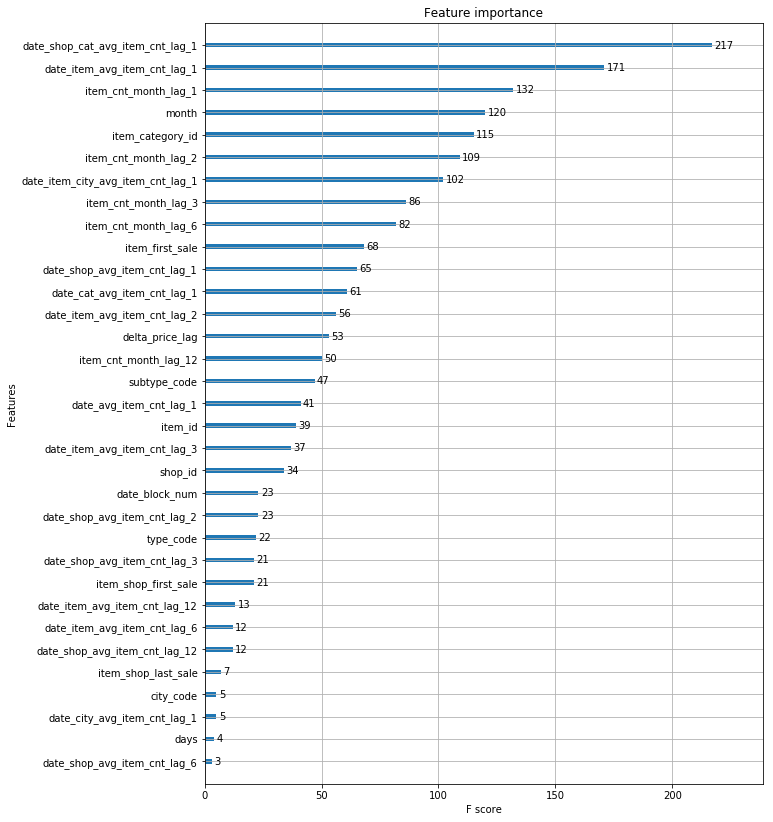

In [113]:
plot_importance_features(model,(10,14))

In [114]:
submission=pd.DataFrame({'Id':test.index})
submission['item_cnt_month']=y_pred
submission.to_csv('submission.csv',index=False)